In [1]:
import firedrake
import matplotlib.pyplot as plt
import icepack.plot
from firedrake import inner, as_vector
import icepack
from firedrake import ds
import numpy as np
import math


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
# Read in the mesh used in the Elmer/Ice simulations

mesh = firedrake.Mesh("mesh/Mesh.msh")


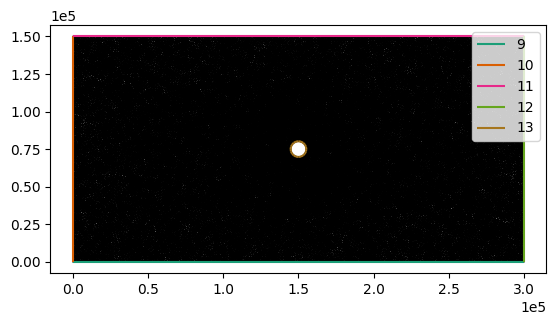

In [3]:
#Plot the mesh

fig, axes = icepack.plot.subplots()
icepack.plot.triplot(mesh, axes=axes)
axes.legend();


In [4]:

x, y = firedrake.SpatialCoordinate(mesh)


In [5]:
# Define the inflow boundary velocity and thickness

u_in = 300.0
h_in = 300.0

us = []

def exp(z):
    return 2.7182818284590**z

u_0_x = 0.0
u_0_y = - u_in / (1.0 + exp(-0.0005*(y-25000.0))) + u_in


In [6]:
# Define the function spaces

Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)


In [7]:

h_expr = firedrake.Constant(h_in)
h0 = firedrake.interpolate(h_expr, Q)
u0 = firedrake.interpolate(firedrake.as_vector((u_0_x, u_0_y)), V)
#u0 = firedrake.interpolate(u_expr, V)


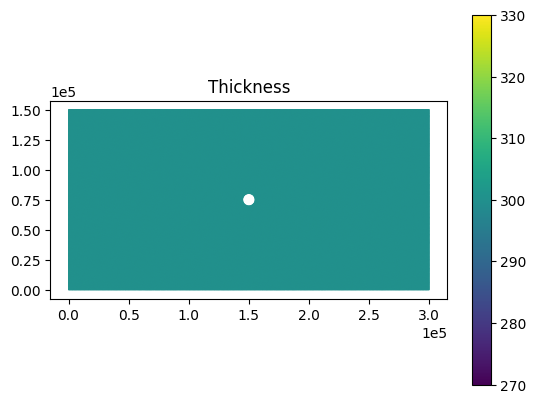

In [8]:
# Plot the initial ice thickness

fig, axes = icepack.plot.subplots()
axes.set_title("Thickness")
colors = icepack.plot.tripcolor(h0, axes=axes)
fig.colorbar(colors);


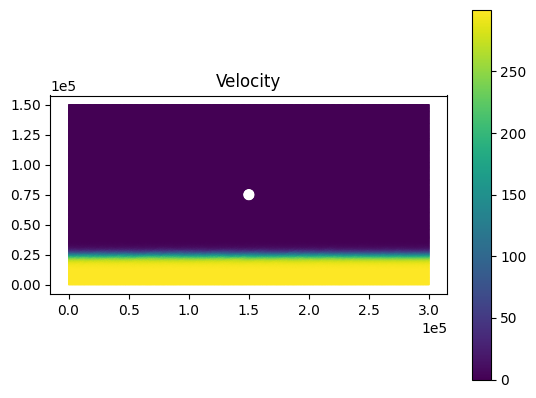

In [9]:
# Plot the initial ice thickness

fig, axes = icepack.plot.subplots()
axes.set_title("Velocity")
colors = icepack.plot.tripcolor(u0, axes=axes)
fig.colorbar(colors);


In [10]:
# Define which model we will be using

model = icepack.models.IceShelf()
#opts = {"dirichlet_ids": [9]}
opts = {"dirichlet_ids": [9, 13], "side_wall_ids": []}
solver = icepack.solvers.FlowSolver(model, **opts)


In [11]:
# Set A(T)

T = firedrake.Constant(255.15)
A = icepack.rate_factor(T)


In [12]:
# Set up the model initially

h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h,
    fluidity=A,
)


In [13]:
import tqdm

final_time = 500
num_timesteps = 1000
dt = final_time / num_timesteps
a = firedrake.Constant(0.0)

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt,
        thickness=h, 
        velocity=u,
        accumulation=a,
        thickness_inflow=h0,
    )
    
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        fluidity=A,
    )

  8%|██▉                                    | 76/1000 [11:28<2:19:25,  9.05s/it]


ConvergenceError: Minimization solver has invalid search direction. This is likely due to a negative thickness or friction coefficient orotherwise physically invalid input data.

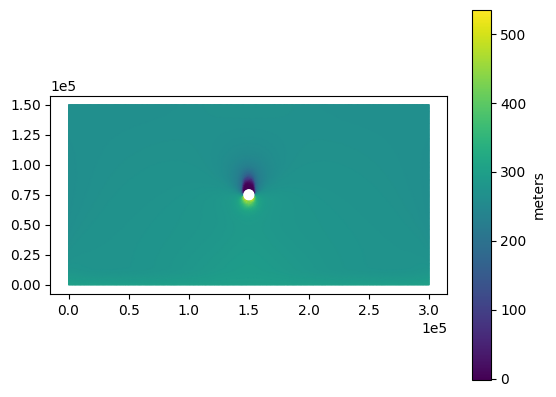

In [14]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(h, axes=axes)
fig.colorbar(colors, label="meters");

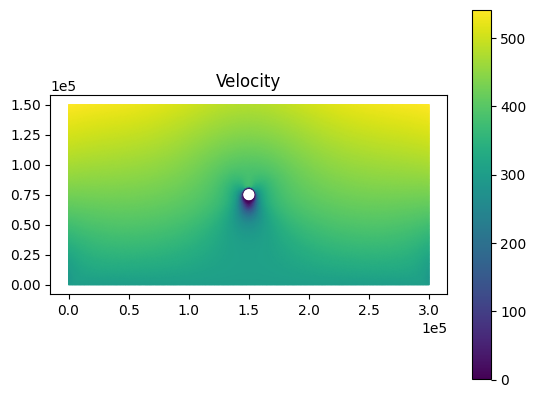

In [17]:

fig, axes = icepack.plot.subplots()
axes.set_title("Velocity")
colors = icepack.plot.tripcolor(u, axes=axes)
fig.colorbar(colors);


In [18]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
)
from firedrake import grad

τ_d = firedrake.interpolate(
    -1e3 * ρ_I * g * (1 - ρ_I / ρ_W) * grad(h**2), V
)

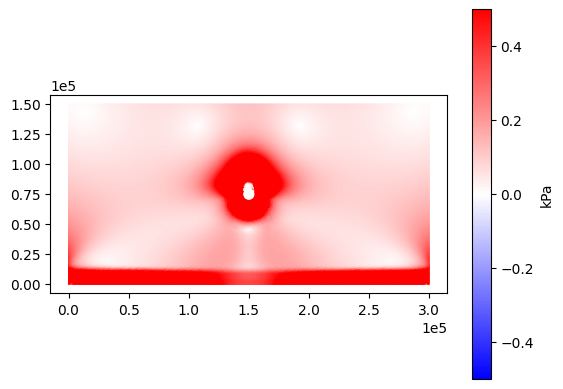

In [21]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(τ_d, vmin=-0.5, vmax=0.5, axes=axes, cmap='bwr')
fig.colorbar(colors, label="kPa");